## Net Returns Maximization

<div class="alert alert-block alert-info"> <b>NOTE</b> This tutorial is experiemental. </div>

This section covers budget optimization by maximizing net returns with the insights from a fitted MMM and a user supplied LTV analysis (in channel level). Behind the scene, we use the `SLSQP` method from `scipy.optim`. It is recommended to learn basic from the [tutorial](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp).

In net returns maximization, the objective function is define as

\begin{align*}
R & = \sum^K_k (\text{LTV}_k - \text{Cost per Acqusition}_k) \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k - \frac{\text{Spend}_k}{\text{Attribution}_k})  \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k \times \text{Attribution}_k  - \text{Spend}_k)
\end{align*}

In [17]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy
# for version print
import orbit
import scipy

from karpiu.planning.optim import ChannelNetProfitMaximizer, TimeNetProfitMaximizer
from karpiu.planning.common import calculate_marginal_cost, generate_cost_report
from karpiu.explainability import AttributorBeta as Attributor

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
print(orbit.__version__)
print(pd.__version__)
print(np.__version__)
print(scipy.__version__)

1.1.4.2
1.4.2
1.24.2
1.10.0


Bring back the fitted model from previous `Quickstart` section.

In [21]:
with open("./resource/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [22]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-31")
optim_channels = mmm.get_spend_cols()

Given the customers life-time value (LTV), one can run the revenue maximization.

In [23]:
ltv_arr = [48.5, 52.5, 38.6, 35.8, 60.8]

### Two-Stage Optimization

#### Optimizing Channel Budget

First, we optimize the budget mix.

In [24]:
%%time
ch_npm = ChannelNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    optim_channels=optim_channels,
    budget_start=budget_start,
    budget_end=budget_end,
    spend_scaler=1.0,
    response_scaler=1.0,
)
temp_optim_spend_df = ch_npm.optimize(maxiter=500, eps=1e-3)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 788456.4147218242
            Iterations: 55
            Function evaluations: 331
            Gradient evaluations: 55
CPU times: user 1.32 s, sys: 649 ms, total: 1.97 s
Wall time: 856 ms


We can retreive the initial and final state of the optimization.

In [27]:
channel_spend_arr = ch_npm.get_current_state()
init_spend_arr = ch_npm.get_init_state()
init_spend_matrix = ch_npm.get_init_spend_matrix()

In [28]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(channel_spend_arr)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_arr)))

Suggested total spend: 490508
Total Budget: 490508


#### Optimizing Budget Allocation across Time

Second, given the condition of budget mix, we optimize the allocation across time.

In [29]:
temp_mmm = deepcopy(mmm)
temp_mmm.raw_df = temp_optim_spend_df
t_npm = TimeNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=temp_mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
    variance_penalty=1e-4,
    spend_scaler=1.0,
    response_scaler=1.0,
)

In [30]:
optim_spend_df = t_npm.optimize(maxiter=500)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 786020.6306643657
            Iterations: 134
            Function evaluations: 4290
            Gradient evaluations: 134


In [31]:
optim_spend_matrix = t_npm.get_current_spend_matrix()

In [32]:
time_based_spend_arr = t_npm.get_current_state()

In [33]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 490508
Total Budget: 490508


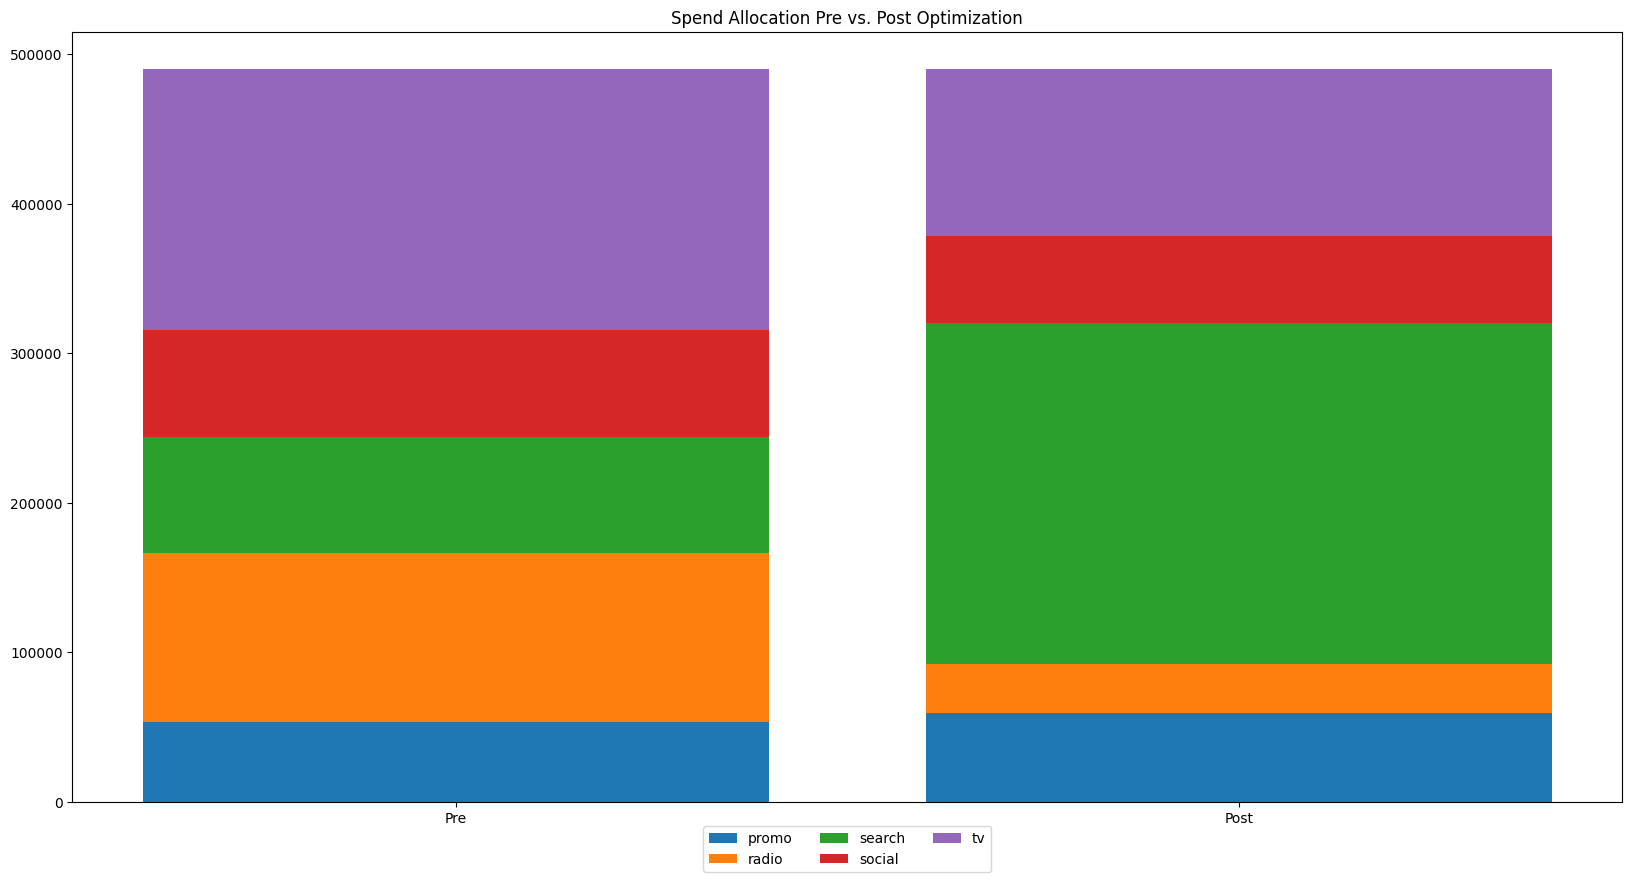

In [34]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

### Validation

#### Average and Marginal Cost Change

In general, one should expect when LTV is greater than the marginal cost under the pre-optimized spend, there should be an increase of spend in the optimal budget. 

In [35]:
df = mmm.get_raw_df()

In [36]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report["ltv"] = ltv_arr
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,ltv
promo,35.39397,33.70702,44.70333,42.91006,53.30000,59.37460,48.50000
radio,72.85242,42.42010,91.75269,51.43140,112.97900,33.15753,52.50000
search,19.46543,29.87292,23.84896,37.64138,78.03300,227.91351,38.60000
social,36.73561,30.49615,45.28456,37.43896,71.64400,58.16055,35.80000
tv,60.20405,45.86189,73.57689,55.21194,174.55200,111.90181,60.80000


In [37]:
pre_mc = cost_report["pre-opt-marginal-cost"].values
overspend = pre_mc > (cost_report["ltv"].values * 1.2)
underspend = pre_mc < (cost_report["ltv"].values * 0.8)
spend_delta = cost_report["post-opt-spend"].values - cost_report["pre-opt-spend"].values
assert np.all(spend_delta[overspend] < 0)
assert np.all(spend_delta[underspend] > 0)

After all, a general condition of marginal cost lower than LTV should be met when spend > 0.

In [17]:
post_mc = cost_report["post-opt-marginal-cost"].values

In [18]:
assert np.all(post_mc < cost_report["ltv"].values * 1.1)

#### Spend Allocation Plot

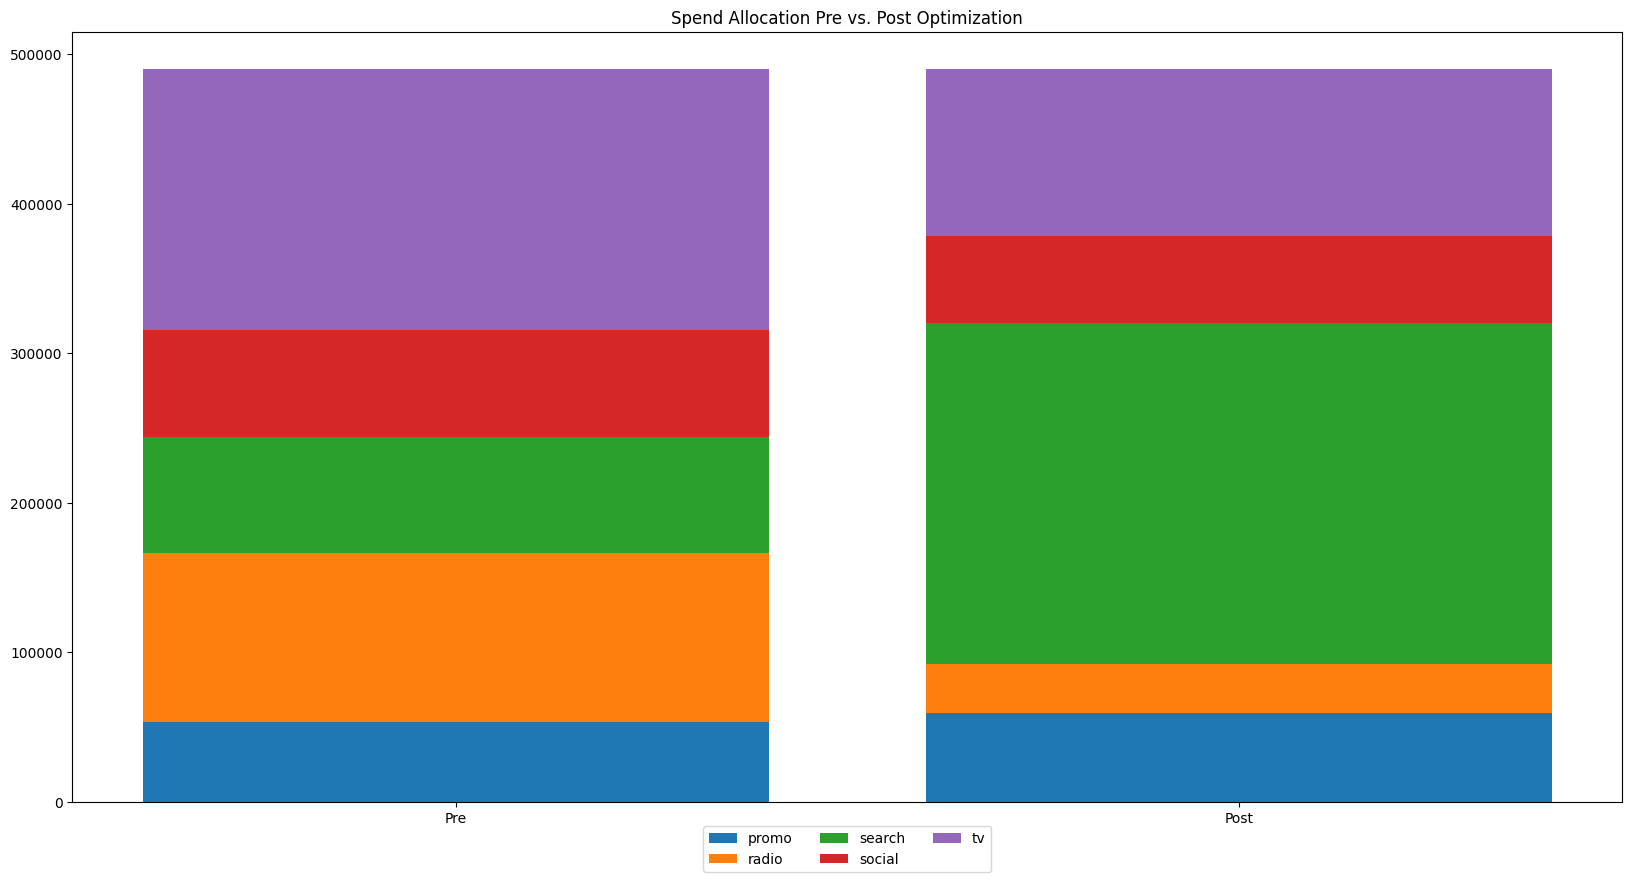

In [38]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

In [94]:
attr_obj = Attributor(
    mmm,
    attr_regressors=optim_channels,
    start=budget_start,
    end=budget_end,
    df=optim_spend_df,
)
res = attr_obj.make_attribution(true_up=False, fixed_intercept=True)

_, spend_attr_df, spend_df, _ = res
base_spend_attr_matrix = np.sum(spend_attr_df[optim_channels].values, 0)
base_spend_matrix = np.sum(spend_df[optim_channels].values, 0)
base_rev = base_spend_attr_matrix * (ltv_arr)
base_net_arr = base_rev - base_spend_matrix
baseline_net_rev = base_net_arr.sum()

In [95]:
baseline_net_rev

147083.14171577903

`base_net_arr` now holds net returns for each channel. `baseline_net_rev` holds the total baseline net returns.

Now, one can iteratively simulate scenarios for each channel with additional spend and derive the delta of net returns between the scenario and the baseline.

In [96]:
delta = 1e-1 * 10000

new_net_revs = np.empty(len(optim_channels))

input_mask = (optim_spend_df["date"] >= budget_start) & (
    optim_spend_df["date"] <= budget_end
)

for idx, ch in enumerate(optim_channels):
    new_spend_df = deepcopy(optim_spend_df)
    delta_matrix = np.zeros_like(new_spend_df.loc[input_mask, optim_channels])
    delta_matrix[:, idx] += delta
    new_spend_df.loc[input_mask, optim_channels] += delta_matrix
    attr_obj = Attributor(
        mmm,
        attr_regressors=optim_channels,
        start=budget_start,
        end=budget_end,
        df=new_spend_df,
    )
    res = attr_obj.make_attribution(true_up=False, fixed_intercept=True)
    _, spend_attr_df, spend_df, _ = res
    new_spend_attr_matrix = np.sum(spend_attr_df[optim_channels].values, 0)
    new_spend_matrix = np.sum(spend_df[optim_channels].values, 0)
    new_rev = new_spend_attr_matrix * (ltv_arr)
    new_net_arr = new_rev - new_spend_matrix
    new_net_revs[idx] = new_net_arr.sum()

Now, `new_net_revs` hold each scenario with small incremental of spend of such channel.

In [97]:
new_net_revs - baseline_net_rev

array([-2856.80416955, -2659.55989309,   259.33891627, -1685.65044645,
        -325.44410458])

Users should see negative delta for all scenarios.

### Simulate Marginal Revenue, Cost and Net Profits

Note: this part would not work if the budget hit the constraints which mean budget can be "improved" if constraints are removed.

In [98]:
attr_obj = Attributor(
    mmm,
    attr_regressors=optim_channels,
    start=budget_start,
    end=budget_end,
    df=optim_spend_df,
)
res = attr_obj.make_attribution(true_up=False, fixed_intercept=True)

_, spend_attr_df, spend_df, _ = res
base_tot_attr_arr = np.sum(spend_attr_df[optim_channels].values, 0)
base_spend_arr = np.sum(spend_df[optim_channels].values, 0)
base_rev = base_tot_attr_arr * (ltv_arr)
base_net_arr = base_rev - base_spend_arr

In [99]:
base_net_arr.sum()

147083.14171577903

In [100]:
input_mask = (optim_spend_df["date"] >= budget_start) & (
    optim_spend_df["date"] <= budget_end
)

In [106]:
delta = 1e-1 * 10000

In [107]:
entries = list()

for idx, ch in enumerate(optim_channels):
    new_spend_df = deepcopy(optim_spend_df)
    delta_matrix = np.zeros_like(new_spend_df.loc[input_mask, optim_channels])
    delta_matrix[:, idx] += delta
    new_spend_df.loc[input_mask, optim_channels] += delta_matrix
    attr_obj = Attributor(
        mmm,
        attr_regressors=optim_channels,
        start=budget_start,
        end=budget_end,
        df=new_spend_df,
    )
    res = attr_obj.make_attribution(true_up=False, fixed_intercept=True)
    _, spend_attr_df, spend_df, _ = res
    # (n_channels, )
    new_spend_attr_arr = np.sum(spend_attr_df[optim_channels].values, 0)
    # (n_channels, )
    new_spend_arr = np.sum(spend_df[optim_channels].values, 0)
    entry = pd.DataFrame({
        "target_channel": ch,
        "channel": optim_channels,
        "base_spend": base_spend_arr,
        "new_tot_spend": new_spend_arr,
        "base_tot_attr": base_tot_attr_arr,
        "new_tot_attr": new_spend_attr_arr,
        "ltv": ltv_arr,
    })
    entries.append(entry)
    
marginal_attr_df = pd.concat(entries, axis=0)
    # new_rev = new_spend_attr_matrix * (ltv_arr)
    # new_net_arr = new_rev - new_spend_matrix
    # new_revs[idx] = new_net_arr.sum()

marginal attribution cost ?

In [108]:
marginal_attr_df["tot_spend_delta"] = marginal_attr_df["new_tot_spend"] - marginal_attr_df["base_spend"]
marginal_attr_df["tot_attr_delta"] = marginal_attr_df["new_tot_attr"] - marginal_attr_df["base_tot_attr"]
marginal_attr_df["rev_delta"] = marginal_attr_df["tot_attr_delta"] * marginal_attr_df["ltv"]

In [109]:
marginal_attr_df.head(100)

,target_channel,channel,base_spend,new_tot_spend,base_tot_attr,new_tot_attr,ltv,tot_spend_delta,tot_attr_delta,rev_delta
0,promo,promo,59374.60301,90374.60301,1761.49054,2136.70505,48.50000,31000.00000,375.21450,18197.90338
1,promo,radio,33157.53050,33157.53050,781.64660,795.74895,52.50000,0.00000,14.10235,740.37348
2,promo,search,227913.51213,227913.51213,7629.43625,7774.76790,38.60000,0.00000,145.33165,5609.80153
3,promo,social,58160.54610,58160.54610,1907.14380,1943.32040,35.80000,0.00000,36.17660,1295.12231
4,promo,tv,111901.80828,111901.80828,2439.97396,2477.80283,60.80000,0.00000,37.82887,2299.99512
0,radio,promo,59374.60301,59374.60301,1761.49054,1775.25377,48.50000,0.00000,13.76322,667.51628
1,radio,radio,33157.53050,64157.53050,781.64660,1227.35324,52.50000,31000.00000,445.70664,23399.59868
2,radio,search,227913.51213,227913.51213,7629.43625,7689.83221,38.60000,0.00000,60.39596,2331.28398
3,radio,social,58160.54610,58160.54610,1907.14380,1923.90027,35.80000,0.00000,16.75647,599.88168
4,radio,tv,111901.80828,111901.80828,2439.97396,2462.04896,60.80000,0.00000,22.07499,1342.15949


In [110]:
marginal_attr_df.groupby(by=["target_channel"])[["tot_spend_delta", "rev_delta"]].sum()

,tot_spend_delta,rev_delta
target_channel,,
promo,31000.00000,28143.19583
radio,31000.00000,28340.44011
search,31000.00000,31259.33892
social,31000.00000,29314.34955
tv,31000.00000,30674.55590
